In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".1"

from jax import numpy as jnp
import jax
import temgymbasic.jax_components as comp
from temgymbasic.jax_run import run_to_end
from temgymbasic.jax_ray import Ray, propagate
from temgymbasic.jax_utils import get_pytree_idx_from_model
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
from scipy.ndimage import zoom

image = plt.imread('SilverFast_Resolution_Target_USAF_1951.png')[:, :, 0]
image_shape = image.shape

# Downsample the image by a factor of 2
downsample_factor = 0.1
image = zoom(image, downsample_factor)
image_shape = image.shape

descan_error = [0.0, 0.0, 0.0, 0.0]
defocus = 0.01
semi_conv = 0.001
camera_length = 1.0
scan_position = (0.1, 0.3)

print(image.shape)

(21, 22)


In [3]:
key = jax.random.PRNGKey(0)
complex_image = image + 1j * jax.random.normal(key, (image.shape))

model = [comp.Sample(z=defocus, complex_image=complex_image, pixel_size=0.0001),
         comp.Descanner(z=defocus, descan_error=descan_error, offset_x = scan_position[0], offset_y = scan_position[1]),
         comp.Detector(z=camera_length, pixel_size=0.001, shape=(image.shape))]

detector_coords = model[-1].get_det_coords()
n_rays = 1
n_rays_dim = int(jnp.sqrt(n_rays))

input_amplitude = 1.0
input_pathlength = 0.0
input_wavelength = 1.0

# Prepare multiple input rays (each row is a separate ray)
r1mx = jnp.linspace(scan_position[0], scan_position[0], n_rays_dim) #x off set
r1my = jnp.linspace(scan_position[1], scan_position[1], n_rays_dim) #y off set
r1m = jnp.stack(jnp.meshgrid(r1mx, r1my), axis=-1).reshape(2, -1)

theta1mx = jnp.linspace(0.0, 0.0, n_rays_dim) #dx off set
theta1my = jnp.linspace(0.0, 0.0, n_rays_dim) #dy off set
theta1m = jnp.stack(jnp.meshgrid(theta1mx, theta1my), axis=-1).reshape(2, -1)

#Create ray input
crossover_z = jnp.zeros((n_rays_dim))
sample_z = jnp.ones((n_rays_dim)) * defocus

input_matrix = jnp.vstack([
    r1m[0:1, :],
    r1m[1:2, :],
    theta1m[0:1, :],
    theta1m[1:2, :],
    jnp.ones((n_rays)).reshape(n_rays)
]).T

input_amplitude = jnp.ones(n_rays_dim)
input_pathlength = jnp.zeros(n_rays_dim)
input_wavelength = jnp.ones(n_rays_dim)
input_blocked = jnp.zeros(n_rays_dim, dtype=float)

Rays = Ray(z=crossover_z, 
           matrix=input_matrix, 
           amplitude=input_amplitude, 
           pathlength=input_pathlength, 
           wavelength=input_wavelength,
           blocked=input_blocked)

batched_run_model = jax.vmap(run_to_end, in_axes=(0, None))
jac_batched_run_model = jax.vmap(jax.jacobian(run_to_end), in_axes=(0, None))

def run_to_end(ray, components):
    for component in components:
        distance = (component.z - ray.z).squeeze()
        ray = propagate(distance, ray)
        ray = component.step(ray)

    return ray

def run_to_component(ray, component):
    distance = (component.z - ray.z).squeeze()
    ray = propagate(distance, ray)
    ray = component.step(ray)
    return ray

batched_run_to_component = jax.vmap(run_to_component, in_axes=(0, None))
jac_run_to_component = jax.vmap(jax.jacobian(run_to_component), in_axes=(0, None))
batched_run_model = jax.vmap(run_to_end, in_axes=(0, None))
jac_batched_run_model = jax.vmap(jax.jacobian(run_to_end), in_axes=(0, None))

jacobians_comp_to_end = []
jacobians_comp_to_comp = []

# Get all jacobians from one component to another
for i in range(len(model)):
    if i == 0:
        ray = Rays
    else:
        distance = (model[i-1].z - ray.z).squeeze()
        ray = propagate(distance, ray)
        ray = model[i-1].step(ray)
    
    jacobian = jac_run_to_component(ray, model[i])
    jacobians_comp_to_comp.append(jacobian)

In [4]:
# Get all jacobians from each component to the end
j=0
for i in range(len(model)+1):
    if i==0:
        ray = Rays
    else:
        for j in range(i):
            distance = (model[j].z - Rays.z)
            ray = propagate(distance, Rays)
            ray = model[j].step(ray)

    jacobians_comp_to_end.append(jac_batched_run_model(ray, model[j:]))

forward_ABCDs = []
inverse_ABCDs = []
for jacobian in jacobians_comp_to_end:
    ABCD_matrices = jacobian.matrix.matrix # partial derivative of dro_dri
    shift_vectors = jacobian.pathlength.matrix # partial derivative of dopl_dri

    ABCD_final = ABCD_matrices.at[0, :, -1].set(shift_vectors[0, :])
    ABCD_final = ABCD_final.at[0, -1, -1].set(1.0)
    forward_ABCDs.append(ABCD_final)
    print('Forward Coordinate Transform (RTM):\n', ABCD_final, '\n')
    inverse_ABCD_final = jnp.linalg.inv(ABCD_final)
    inverse_ABCDs.append(inverse_ABCD_final)
    print('Inverse Coordinate Transform (iRTM):\n', inverse_ABCD_final, '\n')



Forward Coordinate Transform (RTM):
 [[[ 1.     0.     1.     0.    -0.1  ]
  [ 0.     1.     0.     1.    -0.3  ]
  [ 0.     0.     1.     0.    -0.001]
  [ 0.     0.     0.     1.    -0.003]
  [ 0.     0.     0.     0.     1.   ]]] 

Inverse Coordinate Transform (iRTM):
 [[[ 1.          0.         -1.          0.          0.099     ]
  [ 0.          1.          0.         -1.          0.29700002]
  [ 0.          0.          1.          0.          0.001     ]
  [ 0.          0.          0.          1.          0.003     ]
  [ 0.          0.          0.          0.          1.        ]]] 

Forward Coordinate Transform (RTM):
 [[[ 1.    0.    0.99  0.   -0.1 ]
  [ 0.    1.    0.    0.99 -0.3 ]
  [ 0.    0.    1.    0.    0.  ]
  [ 0.    0.    0.    1.    0.  ]
  [ 0.    0.    0.    0.    1.  ]]] 

Inverse Coordinate Transform (iRTM):
 [[[ 1.    0.   -0.99  0.    0.1 ]
  [ 0.    1.    0.   -0.99  0.3 ]
  [ 0.    0.    1.    0.    0.  ]
  [ 0.    0.    0.    1.    0.  ]
  [ 0.    0.    0

In [5]:
forward_ABCDs_comp_to_comp = []
inverse_ABCDs_comp_to_comp = []
total_forward = jnp.eye(5)
total_inverse = jnp.eye(5)
for jacobian in jacobians_comp_to_comp:
    shift_vectors = jacobian.pathlength.matrix
    ABCD_matrices = jacobian.matrix.matrix

    ABCD = ABCD_matrices.at[0, :, -1].set(shift_vectors[0, :])
    ABCD = ABCD.at[0, -1, -1].set(1.0)
    forward_ABCDs_comp_to_comp.append(ABCD)
    # print('Forward Coordinate Transform (RTM):\n', ABCD, '\n')
    inverse_ABCD = jnp.linalg.inv(ABCD)
    inverse_ABCDs_comp_to_comp.append(inverse_ABCD)
    # print('Inverse Coordinate Transform (iRTM):\n', inverse_ABCD, '\n')
    total_forward = ABCD @ total_forward
    total_inverse = inverse_ABCD @ total_inverse

print(total_forward)
print(total_inverse)

print(inverse_ABCDs_comp_to_comp)


[[[ 1.   0.   1.   0.  -0.1]
  [ 0.   1.   0.   1.  -0.3]
  [ 0.   0.   1.   0.   0. ]
  [ 0.   0.   0.   1.   0. ]
  [ 0.   0.   0.   0.   1. ]]]
[[[ 1.   0.  -1.   0.   0.1]
  [ 0.   1.   0.  -1.   0.3]
  [ 0.   0.   1.   0.   0. ]
  [ 0.   0.   0.   1.   0. ]
  [ 0.   0.   0.   0.   1. ]]]
[Array([[[ 1.  ,  0.  , -0.01,  0.  ,  0.  ],
        [ 0.  ,  1.  ,  0.  , -0.01,  0.  ],
        [ 0.  ,  0.  ,  1.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  1.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  1.  ]]], dtype=float32), Array([[[1. , 0. , 0. , 0. , 0.1],
        [0. , 1. , 0. , 0. , 0.3],
        [0. , 0. , 1. , 0. , 0. ],
        [0. , 0. , 0. , 1. , 0. ],
        [0. , 0. , 0. , 0. , 1. ]]], dtype=float32), Array([[[ 1.  ,  0.  , -0.99,  0.  ,  0.  ],
        [ 0.  ,  1.  ,  0.  , -0.99,  0.  ],
        [ 0.  ,  0.  ,  1.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  1.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  1.  ]]], dtype=float32)]


In [31]:
import sympy as sp

x_in, y_in, thetax_in, theta_y_in = sp.symbols('x_in y_in theta_x_in theta_y_in')
x_out, y_out, theta_x_out, theta_y_out = sp.symbols('x_out y_out theta_x_out theta_y_out')

in_coords = sp.Matrix([x_in, y_in, thetax_in, theta_y_in, 1])
out_coords = sp.Matrix([x_out, y_out, theta_x_out, theta_y_out, 1])

in_coords_expr = sp.Eq(in_coords, sp.Matrix(total_inverse[0]) @ out_coords)
x_in_expr = sp.Eq(in_coords_expr.lhs[0], in_coords_expr.rhs[0])
display(x_in_expr)
y_in_expr = sp.Eq(in_coords_expr.lhs[1], in_coords_expr.rhs[1])
display(y_in_expr)
theta_y_out_as_f_of_ys = sp.solve(y_in_expr, theta_y_out)[0]
display(theta_y_out_as_f_of_ys)
theta_x_out_as_f_of_xs = sp.solve(x_in_expr, theta_x_out)[0]
display(theta_x_out_as_f_of_xs)

theta_x_out_as_f_of_xs_lam = sp.lambdify((x_in, x_out), theta_x_out_as_f_of_xs)
theta_y_out_as_f_of_ys_lam = sp.lambdify((y_in, y_out), theta_y_out_as_f_of_ys)

possible_theta_x_outs = theta_x_out_as_f_of_xs_lam(scan_position[0], detector_coords[:, 0])
possible_theta_y_outs = theta_y_out_as_f_of_ys_lam(scan_position[1], detector_coords[:, 1])

Eq(x_in, -1.0*theta_x_out + 1.0*x_out + 0.1)

Eq(y_in, -1.0*theta_y_out + 1.0*y_out + 0.3)

-y_in + y_out + 0.3

-x_in + x_out + 0.1

/tmp/ipykernel_384810/502183339.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


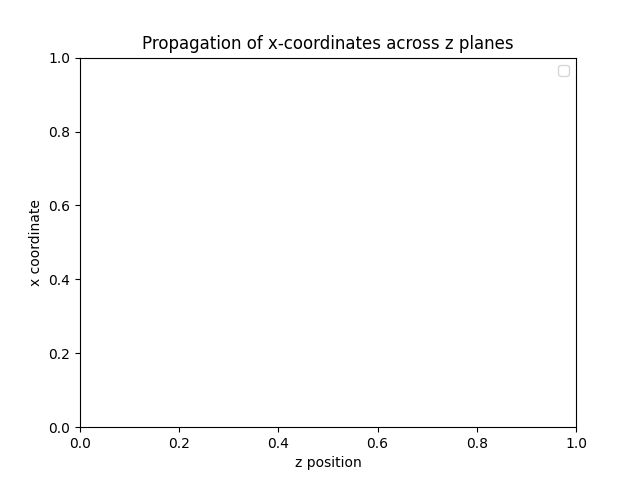

In [ ]:
input_matrix = jnp.vstack([
    detector_coords[:, 0],
    detector_coords[:, 1],
    possible_theta_x_outs,
    possible_theta_y_outs,
    jnp.ones_like(possible_theta_x_outs)
])

zs = [crossover_z[0]] + [component.z for component in model]

zs_inverse = zs[::-1]
inverse_matrices = inverse_ABCDs_comp_to_comp[::-1]

coords = []
coords.append(input_matrix)
for i in range(len(inverse_matrices)):
    inverse_matrix = inverse_matrices[i][0]
    new_coords = jnp.dot(inverse_matrix, coords[i])
    coords.append(new_coords)

coords_array = jnp.array(coords)
xs = coords_array[:, 0, :]
ys = coords_array[:, 1, :]
num_rays = input_matrix.shape[1]

# Extract the z values corresponding to each propagation plane (in reverse order)
z_vals = zs_inverse  # [detector, descanner, sample, crossover]

# Number of rays (columns in the coordinate matrices)
num_rays = input_matrix.shape[1]

plt.figure()
for ray in range(num_rays):
    plt.plot(z_vals, xs[:, ray], label=f'ray {ray}')

plt.figure()
plt.xlabel('z position')
plt.ylabel('x coordinate')
plt.title('Propagation of x-coordinates across z planes')
plt.legend()
plt.show()